In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt 

from statsmodels.stats.proportion import proportion_confint
from tqdm import tqdm, trange

In [2]:
NUM = 21
SKEWS = np.linspace(0, 0.7, num=NUM)
N = 10 ** 3
SAMPLE_SIZES = np.array([10, 50, 100, 150, 200, 500])
FRR = 0.05

In [3]:
shapiro_actual_far = {s: [] for s in SKEWS}
shapiro_errors_far = {s: [] for s in SKEWS}
francia_actual_far = {s: [] for s in SKEWS}
francia_errors_far = {s: [] for s in SKEWS}

for skew in tqdm(SKEWS):
    distribution = sps.pearson3(loc=0, skew=skew)
    for n in SAMPLE_SIZES:
        shapiro_false_acceptances = 0
        francia_false_acceptances = 0
        for _ in range(N):
            sample = distribution.rvs(n)
            _, shapiro_p_value = sps.shapiro(sample)
            _, francia_p_value = sps.normaltest(sample)
            if shapiro_p_value > FRR:
                shapiro_false_acceptances += 1
            if francia_p_value > FRR:
                francia_false_acceptances += 1
        shapiro_cur_far = shapiro_false_acceptances / N
        shapiro_actual_far[skew].append(shapiro_cur_far)
        shapiro_cur_far_low, shapiro_cur_far_high = proportion_confint(shapiro_false_acceptances, N)
        shapiro_errors_far[skew].append([shapiro_cur_far - shapiro_cur_far_low, shapiro_cur_far_high - shapiro_cur_far])

        francia_cur_far = francia_false_acceptances / N
        francia_actual_far[skew].append(francia_cur_far)
        francia_cur_far_low, francia_cur_far_high = proportion_confint(francia_false_acceptances, N)
        francia_errors_far[skew].append([francia_cur_far - francia_cur_far_low, francia_cur_far_high - francia_cur_far])

  0%|          | 0/21 [00:00<?, ?it/s]

/mnt/d/Homework/5_semester/МПС/hse-applied-statistics-methods/venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
100%|██████████| 21/21 [02:10<00:00,  6.21s/it]


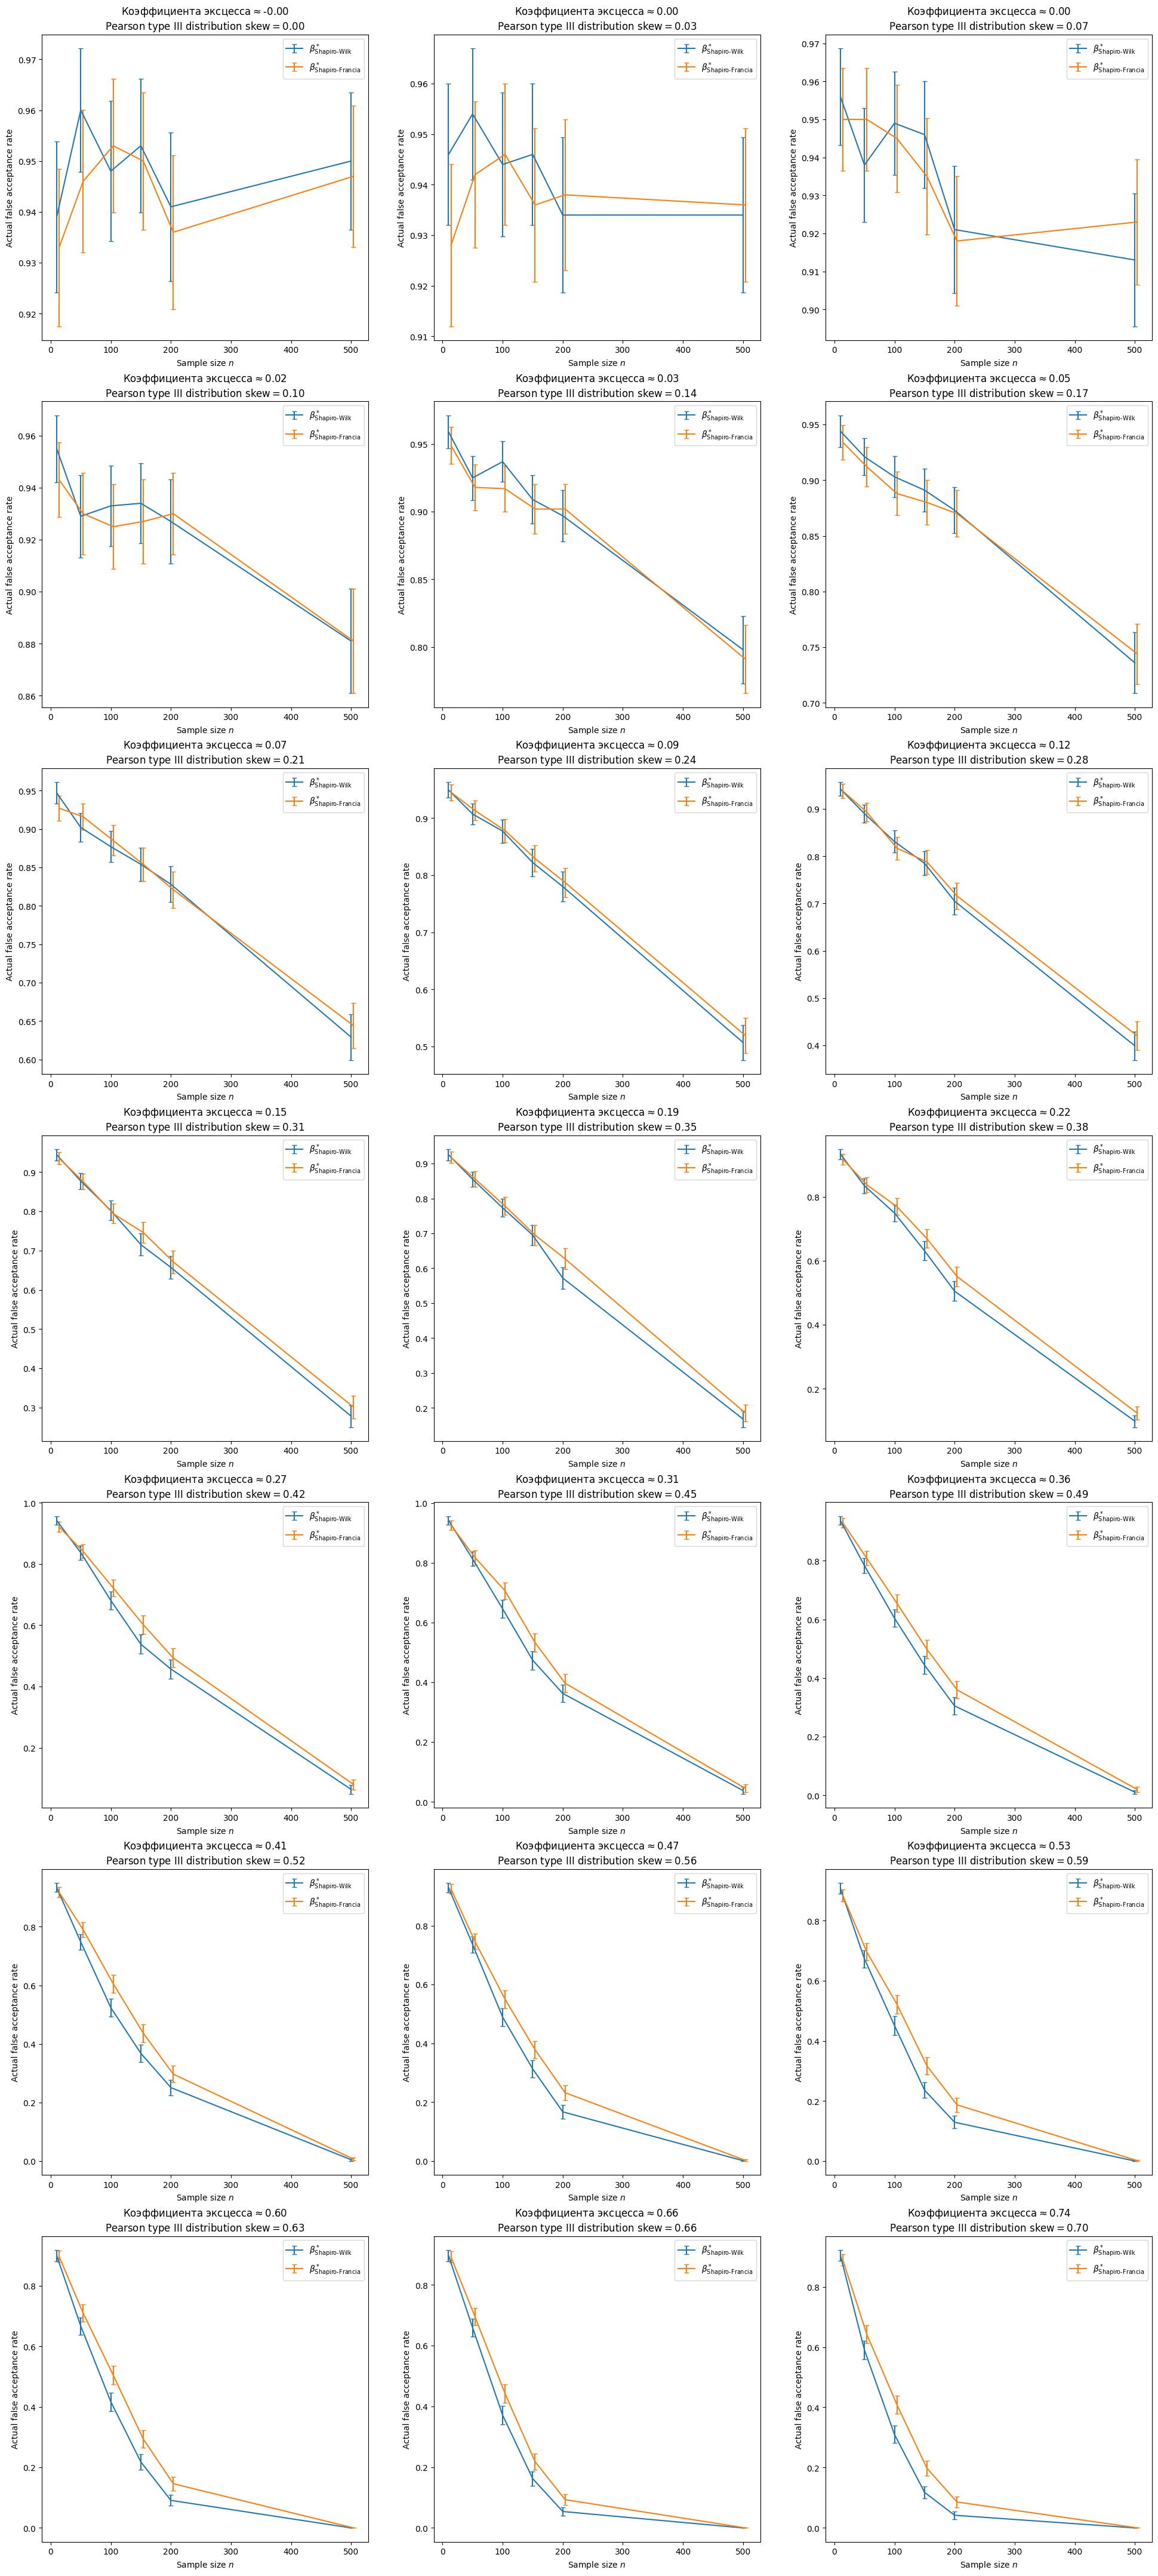

In [4]:
rows = NUM // 3 + NUM % 3
cols = min(3, NUM)
_, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows))
for skew_id, skew in enumerate(SKEWS):
    ax: plt.Axes = axes[skew_id // 3][skew_id % 3]
    ax.errorbar(SAMPLE_SIZES, shapiro_actual_far[skew], np.transpose(shapiro_errors_far[skew]), capsize=3, label='$\\beta^*_{\\text{Shapiro-Wilk}}$')
    ax.errorbar(SAMPLE_SIZES+4, francia_actual_far[skew], np.transpose(francia_errors_far[skew]), capsize=3, label='$\\beta^*_{\\text{Shapiro-Francia}}$')
    ax.set_ylabel('Actual false acceptance rate')
    ax.set_xlabel('Sample size $n$')
    excess_cooefficient = sps.kurtosis(sps.pearson3.rvs(loc=0, skew=skew, size=5_000_000))
    ax.title.set_text(f'Коэффициента эксцесса$\\approx${excess_cooefficient:.2f}\nPearson type III distribution skew$={skew:.2f}$')
    # ax.set_ylim(0, 1)
    ax.legend()
plt.subplots_adjust(bottom=5, top=6)
plt.show()

При больших коэффициентах эксцесса $(>0.2 - 0.3)$ результаты очевидны: меньше ложно положительных результатов даёт Shapiro-Wilk test при любых размерах выборки. При маленьких же всё менее однозначно, но можно определить, что в большинстве случаев Shapiro-Francia всё-таки лучше.  